This is my first kernel.  I am following chapter 2 of Hands-On Machine Learning with Scikit-Learn and Tensorflow by Aurélien Géron for a common approach to implementing machine learning programs.  This book is a wonderful resource for those getting started in machine learning and an excellent resource for more advanced engineers.

In [155]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [156]:
train_df = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])

In [157]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


In [158]:
test_df = pd.read_csv("sample_submission.csv")

In [159]:
test_df = test_df.rename(index=str, columns={"ParcelId": "parcelid"})

In [6]:
properties_2016_df = pd.read_csv("properties_2016.csv")

C:\Users\203014767\.conda\envs\DAND\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [160]:
train_df = pd.merge(train_df, properties_2016_df, on='parcelid', how='left')

In [161]:
test_df = pd.merge(test_df, properties_2016_df, on='parcelid', how='left')

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

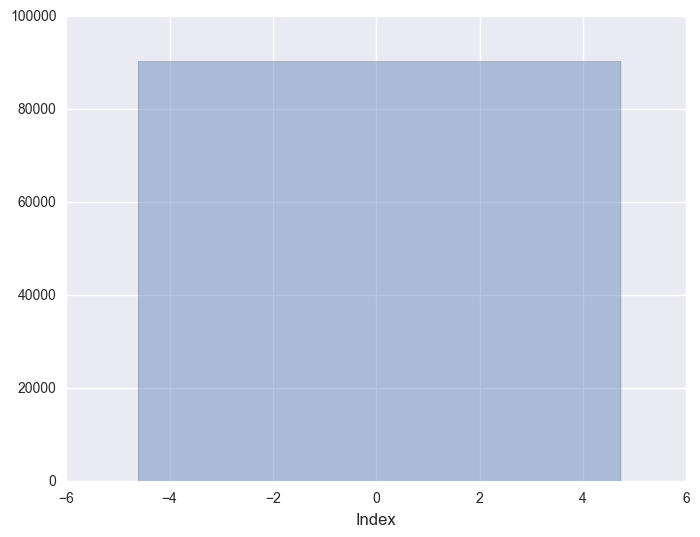

In [11]:
# Let's check the logerror to see how it is distributed and if there are outliers.
import seaborn as sns
plt.figure(figsize=(8,6))
sns.distplot(train_df.logerror.values, bins=1, kde=False)
plt.xlabel('Index', fontsize=12)
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x2ed6b668>],
 'caps': [<matplotlib.lines.Line2D at 0x28d5a080>,
 'fliers': [<matplotlib.lines.Line2D at 0x28d5a7b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x28d5acc0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x3fed8f98>,
  <matplotlib.lines.Line2D at 0x2ed6ba20>]}

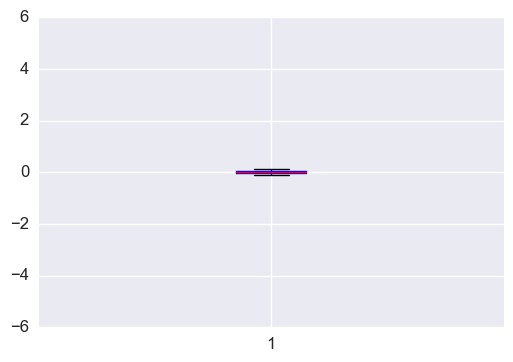

In [163]:
import matplotlib.pyplot as plt
import numpy as np
# basic plot
plt.boxplot(train_df.logerror.values)

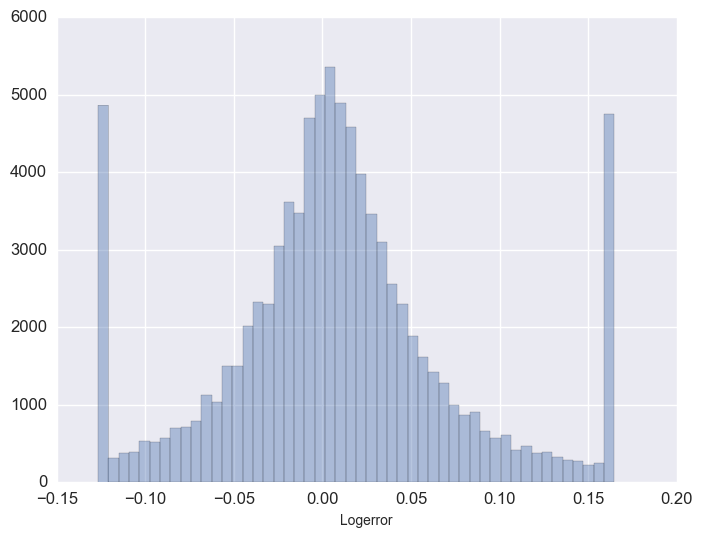

In [164]:
# Let's remove the top and bottom 5% of outliers
outlier_upper = np.percentile(train_df.logerror.values, 95)
outlier_lower = np.percentile(train_df.logerror.values, 5)
train_df['logerror'].ix[train_df['logerror']>outlier_upper] = outlier_upper
train_df['logerror'].ix[train_df['logerror']<outlier_lower] = outlier_lower

plt.figure(figsize=(8,6))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('Logerror', fontsize=10)
plt.show()

In [14]:
corr_matrix = train_df.corr()

In [15]:
corr_matrix["logerror"].sort_values(ascending=False)

logerror                        1.000000
basementsqft                    0.142301
finishedsquarefeet12            0.077463
calculatedfinishedsquarefeet    0.072677
calculatedbathnbr               0.058213
bathroomcnt                     0.057267
fullbathcnt                     0.054740
finishedsquarefeet15            0.052168
fireplacecnt                    0.044177
numberofstories                 0.043762
bedroomcnt                      0.040753
structuretaxvaluedollarcnt      0.034817
yardbuildingsqft26              0.031133
garagetotalsqft                 0.030732
garagecarcnt                    0.030480
yearbuilt                       0.029344
taxvaluedollarcnt               0.025405
threequarterbathnbr             0.023085
censustractandblock             0.019565
roomcnt                         0.018559
fips                            0.018362
rawcensustractandblock          0.018245
landtaxvaluedollarcnt           0.016332
parcelid                        0.014106
airconditioningt

### Prepare the data for Machine Learning algorithms

In [16]:
sample_incomplete_rows = train_df[train_df.isnull().any(axis=1)].head()
sample_incomplete_rows

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1267,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [17]:
Blanks = train_df.isnull().sum() / len(train_df)
Blanks

parcelid                        0.000000
logerror                        0.000000
transactiondate                 0.000000
airconditioningtypeid           0.681185
architecturalstyletypeid        0.997109
basementsqft                    0.999524
bathroomcnt                     0.000000
bedroomcnt                      0.000000
buildingclasstypeid             0.999823
buildingqualitytypeid           0.364564
calculatedbathnbr               0.013093
decktypeid                      0.992711
finishedfloor1squarefeet        0.924054
calculatedfinishedsquarefeet    0.007322
finishedsquarefeet12            0.051831
finishedsquarefeet13            0.999634
finishedsquarefeet15            0.960521
finishedsquarefeet50            0.924054
finishedsquarefeet6             0.995336
fips                            0.000000
fireplacecnt                    0.893581
fullbathcnt                     0.013093
garagecarcnt                    0.668380
garagetotalsqft                 0.668380
hashottuborspa  

#Drop fields with over 75% NANs
train_df = train_df.drop(['taxdelinquencyyear', 'taxdelinquencyflag', 'fireplaceflag', 'yardbuildingsqft26', 
                       'yardbuildingsqft17', 'typeconstructiontypeid', 'storytypeid', 'poolsizesum', 
                       'pooltypeid10', 'pooltypeid2', 'hashottuborspa',
                       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6',
                       'decktypeid', 'finishedfloor1squarefeet', 'buildingclasstypeid', 
                       'architecturalstyletypeid', 'basementsqft', 'architecturalstyletypeid',
                       'threequarterbathnbr', 'fireplacecnt', 'poolcnt', 'pooltypeid7', 'numberofstories'], axis = 1)



In [19]:
Blanks = train_df.isnull().sum() / len(train_df)
Blanks

parcelid                        0.000000
logerror                        0.000000
transactiondate                 0.000000
airconditioningtypeid           0.681185
bathroomcnt                     0.000000
bedroomcnt                      0.000000
buildingqualitytypeid           0.364564
calculatedbathnbr               0.013093
calculatedfinishedsquarefeet    0.007322
finishedsquarefeet12            0.051831
fips                            0.000000
fullbathcnt                     0.013093
garagecarcnt                    0.668380
garagetotalsqft                 0.668380
heatingorsystemtypeid           0.378787
latitude                        0.000000
longitude                       0.000000
lotsizesquarefeet               0.112434
propertycountylandusecode       0.000011
propertylandusetypeid           0.000000
propertyzoningdesc              0.354052
rawcensustractandblock          0.000000
regionidcity                    0.019972
regionidcounty                  0.000000
regionidneighbor

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 35 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
transactiondate                 90275 non-null datetime64[ns]
airconditioningtypeid           28781 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
buildingqualitytypeid           57364 non-null float64
calculatedbathnbr               89093 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
finishedsquarefeet12            85596 non-null float64
fips                            90275 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
garagetotalsqft                 29937 non-null float64
heatingorsystemtypeid           56080 non-null float64
latitude                        90275 non-null float64
longit

In [165]:
#remove categorical variables
train_df = train_df.drop(['propertyzoningdesc', 'propertycountylandusecode', 'transactiondate', 'parcelid'], axis = 1)

In [174]:
train_df = train_df.drop(['taxdelinquencyflag', 'fireplaceflag'], axis = 1)

In [166]:
num_attribs = list(train_df)
num_attribs

['logerror',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'fireplaceflag',
 'structuretaxvaluedollarcnt',
 'taxvalued

In [167]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [168]:
train_df_labels = train_df['logerror'].values

In [169]:
train_df = train_df.drop(['logerror'], axis = 1)

In [209]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split = \
    train_test_split(train_df, train_df_labels, test_size=0.3, random_state=42)

In [232]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestRegressor

num_attribs = list(train_df)

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),        
        ('pca', PCA(n_components = 5)),
        ('KBest', SelectKBest(k = 1)),
        ('reg', RandomForestRegressor(random_state=42))
         ])
        

In [240]:
param_grid = dict(pca__n_components=range(1, 30),
                 reg__min_samples_split = range(1,100),
                 KBest__k = range(1,30))

In [241]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
sss = StratifiedShuffleSplit(100, test_size=0.5, random_state=42)

grid_search = GridSearchCV(num_pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv = sss)

In [242]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search = RandomizedSearchCV(num_pipeline, param_grid=param_grid,
                                n_iter=2, cv=sss, scoring='neg_mean_squared_error', random_state=42)

TypeError: __init__() got an unexpected keyword argument 'param_grid'

In [226]:
grid_fit = grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
select = SelectKBest(score_func = chi2, k = 10)
pca = PCA(n_components = 5)
dt = DecisionTreeClassifier()

# Euclidian distance is not used in decision trees,
# so scaling not necessary
steps = [('scaling', scaler),
    ('feature_selection', select),
    ('reduce_dim', pca),
    ('classifier',dt)]

params = {
    'classifier__min_samples_split': [2,3,4,5],
    'classifier__min_samples_leaf': [2,3,4,5],
    'classifier__max_leaf_nodes': [None,2,3,4,5],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__splitter': ['best','random']
}

sss = StratifiedShuffleSplit(
    n_splits=100,
    test_size=0.5,
)

gs = GridSearchCV(
    Pipeline(steps),
    param_grid = params,
    scoring = 'f1'
)

gs.fit(features_train,labels_train)

# Pass the best algorithm as your clf
clf = gs.best_estimator_

In [175]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 53 columns):
airconditioningtypeid           28781 non-null float64
architecturalstyletypeid        261 non-null float64
basementsqft                    43 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
buildingclasstypeid             16 non-null float64
buildingqualitytypeid           57364 non-null float64
calculatedbathnbr               89093 non-null float64
decktypeid                      658 non-null float64
finishedfloor1squarefeet        6856 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
finishedsquarefeet12            85596 non-null float64
finishedsquarefeet13            33 non-null float64
finishedsquarefeet15            3564 non-null float64
finishedsquarefeet50            6856 non-null float64
finishedsquarefeet6             421 non-null float64
fips                         

In [180]:
train_df_prepared = num_pipeline.fit_transform(train_df)

In [28]:
train_df_prepared

array([[-0.15115791, -0.27828682, -0.02755836, ..., -0.1021705 ,
         0.10996366, -0.58606834],
       [-0.15115791,  1.21534222,  0.83717255, ..., -0.09803808,
         0.6096462 , -0.56117457],
       [-0.15115791,  0.71746587, -0.89228927, ..., -0.55038018,
         0.80434332, -0.56857702],
       ..., 
       [-0.15115791, -0.27828682,  0.83717255, ..., -0.65481196,
        -0.59342075, -0.57010013],
       [-0.15115791, -0.27828682, -0.89228927, ..., -0.61288843,
        -0.54079757, -0.56183814],
       [-0.15115791, -1.27403951, -0.02755836, ..., -0.45333184,
        -0.50052777, -0.56464926]])

In [29]:
train_df_prepared.shape

(90275L, 30L)

# Select and train a model

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df_prepared, train_df_labels, test_size=0.3, random_state=42)

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
from sklearn.metrics import mean_squared_error

lin_train_predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, lin_train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.065983652753749969

In [33]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, lin_train_predictions)
lin_mae

0.048261431561273369

In [34]:
from sklearn.metrics import mean_absolute_error

lin_test_predictions = lin_reg.predict(X_test)
lin_mae_test = mean_absolute_error(y_test, lin_test_predictions)
lin_mae_test

0.048322989763419935

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [36]:
DT_predictions = tree_reg.predict(X_train)
DT_mae_train = mean_absolute_error(y_train, DT_predictions)
DT_mae_train

9.6894649111701968e-05

In [37]:
DT_test_predictions = tree_reg.predict(X_test)
DT_mae_test = mean_absolute_error(y_test, DT_test_predictions)
DT_mae_test

0.07024754783795141

In [38]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [39]:
from sklearn.metrics import mean_absolute_error

RF_predictions = forest_reg.predict(X_train)
RF_mae_train = mean_absolute_error(y_train, RF_predictions)
RF_mae_train

0.02062647160405074

In [42]:
k = 5

In [43]:
best_features_indices = best_features(feature_importances, k)
best_features_indices

array([12, 14, 24, 27, 28], dtype=int64)

In [44]:
np.array(num_attribs)[best_features_indices]

array(['latitude', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount'], 
      dtype='|S28')

In [45]:
# Double check these are the correct features
sorted(zip(feature_importances, num_attribs), reverse=True)[:k]

[(0.090093506302282342, 'structuretaxvaluedollarcnt'),
 (0.087844990951299995, 'lotsizesquarefeet'),
 (0.087332157132958138, 'taxamount'),
 (0.077473532884184113, 'latitude'),
 (0.077211091580067046, 'landtaxvaluedollarcnt')]

In [46]:
RF_test_predictions = forest_reg.predict(X_test)
RF_mae_test = mean_absolute_error(y_test, RF_test_predictions)
RF_mae_test

0.051673108808678515

In [55]:
#train__df_prepared2[0:30,best_features_indices]

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{u'n_estimators': [3, 10, 30], u'max_features': [2, 4, 6, 8]}, {u'n_estimators': [3, 10], u'max_features': [2, 3, 4], u'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=u'neg_mean_squared_error', verbose=0)

In [63]:
grid_search.best_params_

{u'max_features': 4, u'n_estimators': 30}

In [64]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [65]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.0760987972241 {u'max_features': 2, u'n_estimators': 3}
0.0691311499263 {u'max_features': 2, u'n_estimators': 10}
0.0669133296311 {u'max_features': 2, u'n_estimators': 30}
0.0762668376348 {u'max_features': 4, u'n_estimators': 3}
0.0691161976827 {u'max_features': 4, u'n_estimators': 10}
0.0669093468582 {u'max_features': 4, u'n_estimators': 30}
0.0760632469742 {u'max_features': 6, u'n_estimators': 3}
0.0690521173453 {u'max_features': 6, u'n_estimators': 10}
0.0670425142241 {u'max_features': 6, u'n_estimators': 30}
0.0763602105178 {u'max_features': 8, u'n_estimators': 3}
0.0692381016636 {u'max_features': 8, u'n_estimators': 10}
0.067022082971 {u'max_features': 8, u'n_estimators': 30}
0.0764339929265 {u'max_features': 2, u'n_estimators': 3, u'bootstrap': False}
0.0698577216083 {u'max_features': 2, u'n_estimators': 10, u'bootstrap': False}
0.0763033393808 {u'max_features': 3, u'n_estimators': 3, u'bootstrap': False}
0.0696985158968 {u'max_features': 3, u'n_estimators': 10, u'bootstrap': Fa

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={u'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003BC54978>, u'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003BC544E0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=u'neg_mean_squared_error',
          verbose=0)

In [67]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.0660741247009 {u'max_features': 7, u'n_estimators': 180}
0.0680199542317 {u'max_features': 5, u'n_estimators': 15}
0.0662848444109 {u'max_features': 3, u'n_estimators': 72}
0.0673987583603 {u'max_features': 5, u'n_estimators': 21}
0.0661713651962 {u'max_features': 7, u'n_estimators': 122}
0.0662634229794 {u'max_features': 3, u'n_estimators': 75}
0.0661989301312 {u'max_features': 3, u'n_estimators': 88}
0.0661600501404 {u'max_features': 5, u'n_estimators': 100}
0.0660719013187 {u'max_features': 3, u'n_estimators': 150}
0.0804713005094 {u'max_features': 5, u'n_estimators': 2}


In [68]:
rnd_search.best_params_

{u'max_features': 3, u'n_estimators': 150}

In [69]:
grid_search.best_params_

{u'max_features': 4, u'n_estimators': 30}

Let's see which search (grid or random) creates the better tuned model

In [70]:
final_model_grid = grid_search.best_estimator_

In [72]:
final_model_rand = rnd_search.best_estimator_

In [74]:
from sklearn.metrics import mean_absolute_error

grid_predictions = final_model_grid.predict(X_train)
grid_mae_train = mean_absolute_error(y_train, grid_predictions)

rand_predictions = final_model_rand.predict(X_train)
rand_mae_train = mean_absolute_error(y_train, rand_predictions)


In [77]:
final_model_rand

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [75]:
grid_predictions_test = final_model_grid.predict(X_test)
grid_mae_test = mean_absolute_error(y_test, grid_predictions_test)

rand_predictions_test = final_model_rand.predict(X_test)
rand_mae_test = mean_absolute_error(y_test, rand_predictions_test)


In [76]:
# The slight edge goes to the grid search
print("Grid Search Train:")
print(grid_mae_train)
print("Random Search Train:")
print(rand_mae_train)

print("Grid Search Test:")
print(grid_mae_test)
print("Random Search Test:")
print(rand_mae_test)

Grid Search Train:
0.0189056725846
Random Search Train:
0.0180769066691
Grid Search Test:
0.0496360430234
Random Search Test:
0.0486986498255


In [79]:
#cross-validation comes at the cost of training the model several times, so it is not always possible.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_model_rand, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
rand_cross_val_scores = np.sqrt(-scores) 

In [80]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [81]:
display_scores(rand_cross_val_scores)

Scores: [ 0.06644781  0.06630147  0.06622159  0.06591464  0.0666785   0.06637825
  0.06582649  0.06675674  0.06542526  0.06467863]
Mean: 0.0660629377281
Standard deviation: 0.000599227489634


In [82]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_model_grid, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
grid_cross_val_scores = np.sqrt(-scores) 

In [83]:
display_scores(grid_cross_val_scores)

Scores: [ 0.06710868  0.06722905  0.06693543  0.06626485  0.06772263  0.06722009
  0.06667807  0.06766444  0.06632164  0.06578021]
Mean: 0.0668925096231
Standard deviation: 0.000596418338654


In [73]:
from sklearn.externals import joblib

joblib.dump(final_model_grid, "final_model_grid.pkl")
joblib.dump(final_model_rand, "final_model_rand.pkl")

[u'final_model_rand.pkl']

In [94]:
best_param = rnd_search.best_params_

In [141]:
best_param

{u'max_features': 3, u'n_estimators': 150}

In [95]:
joblib.dump(best_param, "best_param.pkl")

[u'best_param.pkl']

In [84]:
feature_importances_rnd = rnd_search.best_estimator_.feature_importances_
feature_importances_rnd

array([ 0.00126775,  0.01185681,  0.02260268,  0.00836105,  0.01098347,
        0.06766993,  0.06292689,  0.001523  ,  0.00884787,  0.00337853,
        0.01341617,  0.00676336,  0.06853979,  0.06764644,  0.06574076,
        0.00954449,  0.05089406,  0.02762495,  0.00149986,  0.02747774,
        0.04462082,  0.00720016,  0.00390678,  0.05977306,  0.07358035,
        0.07219175,  0.        ,  0.07201169,  0.07715877,  0.05099102])

In [89]:
best_features_rnd = best_features(feature_importances_rnd, 5)
best_features_rnd

array([12, 24, 25, 27, 28], dtype=int64)

In [96]:
joblib.dump(feature_importances_rnd, "feature_importances_rnd.pkl")

[u'feature_importances_rnd.pkl']

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin

def best_features(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = best_features(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [92]:
np.array(num_attribs)[best_features_rnd]

array(['latitude', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount'], 
      dtype='|S28')

In [93]:
# Double check feature importance
k = 5
sorted(zip(feature_importances_rnd, num_attribs), reverse=True)[:k]

[(0.07715877391738428, 'taxamount'),
 (0.07358035310788065, 'structuretaxvaluedollarcnt'),
 (0.072191750870598537, 'taxvaluedollarcnt'),
 (0.072011692924132883, 'landtaxvaluedollarcnt'),
 (0.068539787760062879, 'latitude')]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train__df_prepared_bestfeatures, train_df_labels, test_size=0.3, random_state=42)

train__df_prepared_bestfeatures = prepare_select_pipeline.fit_transform(train_df)

train__df_prepared_bestfeatures[0:3]

In [ ]:
# Final predictions

test_df_prepared = prepare_select_pipeline.transform(test_df)
final_predictions = final_model.predict(X_test_prepared)

In [118]:
# Include same features for training and test set
test_df = test_df.drop(['propertyzoningdesc', 'propertycountylandusecode', 'parcelid',
                        'taxdelinquencyyear', 'taxdelinquencyflag', 'fireplaceflag', 'yardbuildingsqft26', 
                       'yardbuildingsqft17', 'typeconstructiontypeid', 'storytypeid', 'poolsizesum', 
                       'pooltypeid10', 'pooltypeid2', 'hashottuborspa',
                       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6',
                       'decktypeid', 'finishedfloor1squarefeet', 'buildingclasstypeid', 
                       'architecturalstyletypeid', 'basementsqft', 'architecturalstyletypeid',
                       'threequarterbathnbr', 'fireplacecnt', 'poolcnt', 'pooltypeid7', 'numberofstories', '201610',
                        '201611','201612', '201710', '201711', '201712'], axis = 1)

In [119]:
test_df.shape

(2985217, 30)

In [120]:
# prepare test data for machine learning
num_attribs_test = list(test_df)


In [133]:
#add feature importance to pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

prepare_select_pipeline = Pipeline([
        ('preparation', num_pipeline),
        ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [137]:
train_df_prepared2 = prepare_select_pipeline.fit_transform(train_df)

In [149]:
from sklearn.model_selection import train_test_split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(train_df_prepared2, 
                                                                            train_df_labels, test_size=0.3, random_state=42)

In [138]:
test_df_prepared = prepare_select_pipeline.transform(test_df)

In [139]:
test_df_prepared.shape

(2985217L, 5L)

In [144]:
final_reg = RandomForestRegressor(max_features = 3, n_estimators = 150)

In [151]:
final_reg.fit(X_train_final, y_train_final)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [152]:
RF_rand_final_predictions = final_reg.predict(test_df_prepared)

In [153]:
submission_file = pd.read_csv('sample_submission.csv') 
for column in submission_file.columns[submission_file.columns != 'ParcelId']:
    submission_file[column] = RF_rand_final_predictions

In [154]:
submission_file.to_csv('RF_final_predictions.csv', index=False, float_format='%.4f')